In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Set GPU as dedicated device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load Data 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


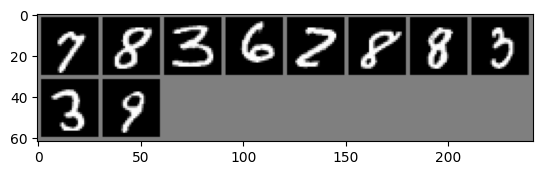

Labels: [7, 8, 3, 6, 2, 8, 8, 3, 3, 9]


In [5]:
# Check if images downloaded correctly
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))
print('Labels:', labels[:10].tolist())


In [ ]:
# Define CNN, Loss Function & Optimizer
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))        
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Train the CNN
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(images)    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Finished Training")

Epoch 1, Loss: 0.1576
Epoch 2, Loss: 0.0521
Epoch 3, Loss: 0.0355
Epoch 4, Loss: 0.0276
Epoch 5, Loss: 0.0224
Finished Training


In [8]:
# Evaluate the Model
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 98.67%


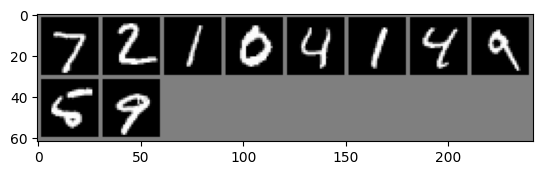

Predicted Labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Actual Labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [9]:
# Visualize Some Predictions
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images.cpu()[:10]))
print("Predicted Labels:", predicted[:10].tolist())
print("Actual Labels:", labels[:10].tolist())
